Music Recommendation System

In [1]:
!pip install kaggle -q

Imorting the Dependencies

In [2]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt


Data Collection

In [3]:
kaggel_config = json.load(open('kaggle.json'))

In [4]:
kaggel_config.keys()

dict_keys(['username', 'key'])

Set Up Enviroment Variables

In [5]:
os.environ['KAGGLE_USERNAME'] = kaggel_config['username']
os.environ['KAGGLE_KEY'] = kaggel_config['key']

In [6]:
#loading the dataset
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
spotify-million-song-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

kaggle.json  spotify-million-song-dataset.zip
sample_data  spotify_millsongdata.csv


In [8]:
with zipfile.ZipFile('spotify-million-song-dataset.zip','r') as zip_ref:
  zip_ref.extractall()

In [9]:
#loading dataset
df = pd.read_csv('spotify_millsongdata.csv')

In [10]:
df.shape

(57650, 4)

In [11]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [13]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [14]:
#top artists and songs
top_artists = df['artist'].value_counts().head(10)
print('\nTop Artists')
print(top_artists)


Top Artists
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [15]:
df.sample(10000)

,artist,song,link,text
24968,Bee Gees,Breakout,/b/bee+gees/breakout_20015804.html,It don't matter who you are \r\nAnyone can be...
39307,Kanye West,Punch Drunk Love,/k/kanye+west/punch+drunk+love_21040933.html,"Come on, come on, come on, come on \r\nCome o..."
40928,Kyla,Doin' Just Fine,/k/kyla/doin+just+fine_20730862.html,There was a time when I thought life was over ...
27491,Children,Five Little Froggies,/c/children/five+little+froggies_20795079.html,Five little froggies sat on a shore \r\n(Chil...
38850,Joy Division,Day Of The Lords,/j/joy+division/day+of+the+lords_20075952.html,"This is the room, the start of it all, \r\nNo..."
...,...,...,...,...
55868,Weezer,Photograph,/w/weezer/photograph_20145663.html,If you want it (oo-oo-oo) \r\nYou can have it...
30280,Doobie Brothers,Road Angel,/d/doobie+brothers/road+angel_20042571.html,I was ridin' down that highway \r\nSilver Har...
6631,George Harrison,Old Brown Shoe,/g/george+harrison/old+brown+shoe_20059130.html,I want a love that's right \r\nRight is only ...
9725,Joni Mitchell,Face Lift,/j/joni+mitchell/face+lift_20075430.html,I went so numb on Christmas day \r\nI couldn'...


In [16]:
df = df.drop('link', axis=1).reset_index(drop=True)
df = df.sample(1000).reset_index(drop=True)

In [17]:
#wordcloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)

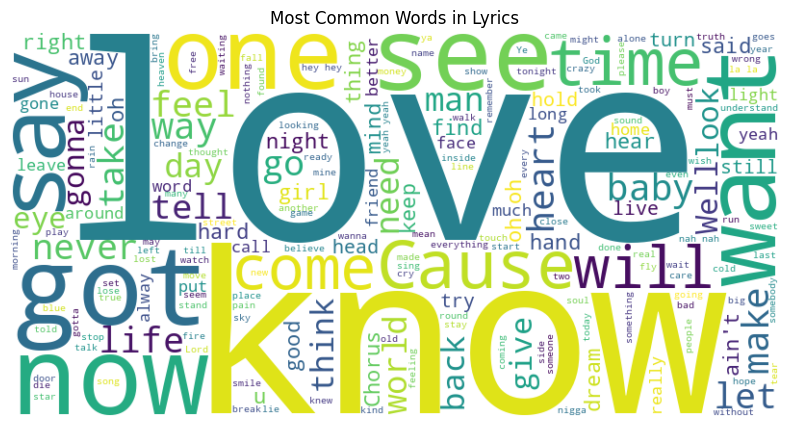

In [18]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Lyrics')
plt.show()

Data Preprocessing

In [19]:


#nltk data download
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words('english'))

In [21]:
def preprocess_text(text):
  #remove special characters and numbers
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  #convert to lower case
  text = text.lower()
  #tokenization
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

In [22]:
#applying preprocessing to text
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [23]:
#vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [24]:
#compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [25]:
#recommendation finction
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
  #find the index of the song
  idx = df[df['song'].str.lower() == song_name.lower()].index
  if len(idx) == 0:
    return "Song not found in the dataset"
  idx = idx[0]

  #get similarity score
  sim_score = list(enumerate(cosine_sim[idx]))
  sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
  sim_score = sim_score[1:top_n+1]

  #get song indices
  song_indices = [i[0] for i in sim_score]

  #return top n similar songs
  return df[['artist','song']].iloc[song_indices]

In [26]:
df['song'][2]

'I Love The Woman'

In [27]:
#Example Recommendation
print('Recommended Songs:')
print(recommend_songs('I Love The Woman'))


Recommended Songs:
            artist                song
834    The Beatles         I Feel Fine
553        Nirvana         I Feel Fine
212  Willie Nelson  Good Hearted Woman
288      Marillion    Map Of The World
281      Scorpions        Taxman Woman
